In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import networkx as nx
from collections import defaultdict
import csv
import pickle
from datetime import datetime
#import swifter

In [93]:
#Import movement data
with open('/home/mxenoc/workspace/pickles/RISE/weekly_movements_SC.pkl', 'rb') as f:
    weekly_movements = pickle.load(f)
    
#Import covid data
with open('/home/mxenoc/workspace/pickles/RISE/weekly_infections.pkl', 'rb') as f:
    weekly_infections = pickle.load(f)
    
with open('/home/mxenoc/workspace/pickles/RISE/SC_cities.pkl', 'rb') as f:
    SC_cities = pickle.load(f)

In [94]:
weekly_movements = weekly_movements[weekly_movements.origin_city.isin(SC_cities)]
weekly_movements = weekly_movements[weekly_movements.destination_city.isin(SC_cities)]
weekly_infections = weekly_infections[weekly_infections.place.isin(SC_cities)]

In [95]:
#Pick a week to plot
date = '2021-02-09'
weekly_movements = weekly_movements[weekly_movements.date == date]
weekly_infections = weekly_infections[weekly_infections.date == date]

In [96]:
weekly_movements

,,origin_city,destination_city,device_count_normalised,date
CampbellCampbell,307,Campbell,Campbell,41899.857143,2021-02-09
CampbellCupertino,307,Campbell,Cupertino,634.285714,2021-02-09
CampbellGilroy,307,Campbell,Gilroy,267.000000,2021-02-09
CampbellLos Altos,307,Campbell,Los Altos,387.142857,2021-02-09
CampbellLos Gatos,307,Campbell,Los Gatos,2380.714286,2021-02-09
...,...,...,...,...,...
SunnyvalePalo Alto,307,Sunnyvale,Palo Alto,2265.142857,2021-02-09
SunnyvaleSan Jose,307,Sunnyvale,San Jose,15592.000000,2021-02-09
SunnyvaleSanta Clara,307,Sunnyvale,Santa Clara,10277.571429,2021-02-09
SunnyvaleSaratoga,307,Sunnyvale,Saratoga,750.142857,2021-02-09


In [97]:
weekly_movements

,,origin_city,destination_city,device_count_normalised,date
CampbellCampbell,307,Campbell,Campbell,41899.857143,2021-02-09
CampbellCupertino,307,Campbell,Cupertino,634.285714,2021-02-09
CampbellGilroy,307,Campbell,Gilroy,267.000000,2021-02-09
CampbellLos Altos,307,Campbell,Los Altos,387.142857,2021-02-09
CampbellLos Gatos,307,Campbell,Los Gatos,2380.714286,2021-02-09
...,...,...,...,...,...
SunnyvalePalo Alto,307,Sunnyvale,Palo Alto,2265.142857,2021-02-09
SunnyvaleSan Jose,307,Sunnyvale,San Jose,15592.000000,2021-02-09
SunnyvaleSanta Clara,307,Sunnyvale,Santa Clara,10277.571429,2021-02-09
SunnyvaleSaratoga,307,Sunnyvale,Saratoga,750.142857,2021-02-09


In [98]:
#Keep the columns you want for the graph and rename them
links = weekly_movements[['origin_city', 'destination_city', 'device_count_normalised']]
links.columns = ['var1', 'var2', 'weight']

In [99]:
#origin = links[links.var1.isin(Alameda_cities)] 
#destination = links[links.var2.isin(Alameda_cities)]
#links = pd.concat([origin, destination]).drop_duplicates()

In [100]:
# Edges you want to include
threshold = 0.9
links_filtered = links.loc[ (abs(links['weight']) > threshold) & (links['var1'] != links['var2']) ]

G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr=True)

# Edges you want to plot
edges_filtered = [(u,v) for (u, v, e) in G.edges(data=True) if e['weight'] > threshold]
weights_filtered = [e['weight'] for (u, v, e) in G.edges(data=True) if e['weight'] > threshold]

In [101]:
G

In [102]:
# Choose the layout
pos = nx.spring_layout(G, scale = 0.8, k = 0.7)

In [103]:
# Add groups
node_colors = pd.DataFrame({'features': weekly_infections['place'], 'group': weekly_infections['new_cases_per1000']})

In [104]:
node_colors = node_colors.set_index('features')
# Reindex your nodes to match the graph's nodes
node_colors_reind = node_colors.reindex(G.nodes())
node_colors_reind['group'] = pd.Categorical(node_colors_reind['group'])
node_colors_reind = node_colors_reind['group'].cat.codes
node_colors_reind[node_colors_reind == -1] = -50

In [105]:
#Get the number of incoming traffic for each city
movement_cities_inc = weekly_movements[weekly_movements.origin_city != weekly_movements.destination_city]
movement_cities_inc = movement_cities_inc.groupby(['date', 'destination_city'], as_index=False)['device_count_normalised'].sum()
movement_cities_inc = movement_cities_inc.set_index('destination_city')

In [106]:
# Reindex your nodes to match the graph's nodes
movement_cities_inc = movement_cities_inc.reindex(G.nodes())
movement_cities_inc['total_moving_devices'] = pd.Categorical(movement_cities_inc['device_count_normalised'])
movement_cities_inc = movement_cities_inc['total_moving_devices'].cat.codes

In [107]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap_greys = plt.get_cmap('Greys')
cmap_reds = plt.get_cmap('Reds')

In [108]:
# Make a list of the labels you want to show on the graph
labels = {}    
for node in G.nodes():
    #set the node name as the key and the label as its value 
    labels[node] = node

In [109]:
include_labels = node_colors_reind[node_colors_reind>-10].index

In [110]:
labels = {k: labels[k] for k in include_labels}

In [111]:
#labels['Coachella'] = 'Coachella'
#labels['Bakersfield'] = 'Bakersfield'

In [112]:
len(labels)

13

/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


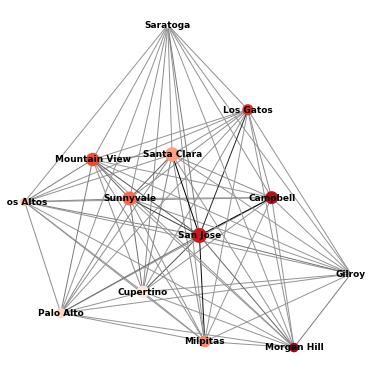

In [113]:
nx.draw(G, with_labels=False, pos = pos, 
                              edgelist = edges_filtered, 
                              edge_color = weights_filtered, 
                              edge_cmap=truncate_colormap(cmap_greys, 0.5, 1), 
                              node_color = node_colors_reind,
#                              node_size = [v**3+4 for v in -np.log10(node_colors_reind['p_value'])], 
#                              node_size = (day_2_10['completely_home_device_count']*3**6), 
#                             node_size = -np.log10(node_colors_reind['p_value']), 
                              node_size = movement_cities_inc*10,#/20,
                              linewidths = 4, font_size = 1, 
                              cmap=truncate_colormap(cmap_reds, 0, 1))

#Finally, redraw the labels at their new position.
nx.draw_networkx_labels(G, pos, labels, font_color = 'black', font_weight = 'bold', font_size = 9)
#nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white')

figure = plt.gcf() # get current figure
figure.set_size_inches(5, 5)
#plt.savefig('/home/mxenoc/workspace/covid-CA-forecasting/plots/covid_01_12_week.png', dpi = 500)

/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


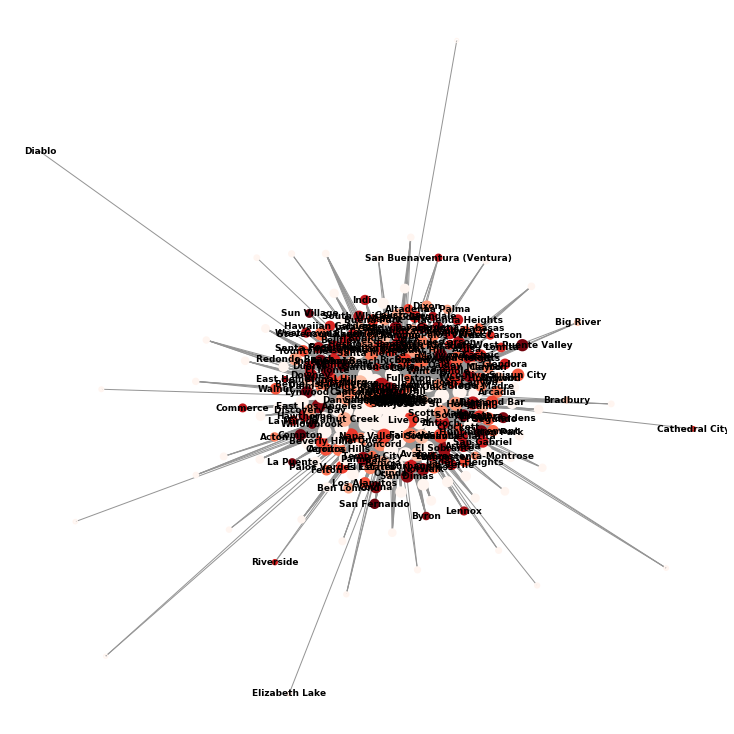

In [91]:
nx.draw(G, with_labels=False, pos = pos, 
                              edgelist = edges_filtered, 
                              edge_color = weights_filtered, 
                              edge_cmap=truncate_colormap(cmap_greys, 0.5, 1), 
                              node_color = node_colors_reind,
#                              node_size = [v**3+4 for v in -np.log10(node_colors_reind['p_value'])], 
#                              node_size = (day_2_10['completely_home_device_count']*3**6), 
#                             node_size = -np.log10(node_colors_reind['p_value']), 
                              node_size = movement_cities_inc*10/20,
                              linewidths = 4, font_size = 1, 
                              cmap=truncate_colormap(cmap_reds, 0, 1))

#Finally, redraw the labels at their new position.
nx.draw_networkx_labels(G, pos, labels, font_color = 'black', font_weight = 'bold', font_size = 9)
#nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white')

figure = plt.gcf() # get current figure
figure.set_size_inches(10, 10)
#plt.savefig('/home/mxenoc/workspace/covid-CA-forecasting/plots/covid_01_12_week.png', dpi = 500)